In [1]:
from datasets import load_dataset
import pandas as pd
import huggingface_hub
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.scorer import Scorer
import json

##### Helper functions

In [2]:
def get_ground_truth(file_name):
    ''' Read the ground truth from the json file and return the entities
        Input: file_name: the name of the json file'''
    
    file = open(file_name, "r")
    annotations = json.load(file)
    return annotations['annotations'][0][1]

In [3]:
def compute_ner_metric(predicted_entities, ground_truth_entities):
    ''' Compute the precision, recall, f1-score and accuracy for the predicted entities
        Input: predicted_entities: the list of predicted entities, tuples (word, entity)
               ground_truth_entities: the list of ground truth entities, tuples (word, entity)'''
    
    # Initialize counters for TP, FP, and FN
    tp, fp, fn = 0, 0, 0

    # Create sets of predicted entities and ground truth entities
    predicted_entities_set = set(predicted_entities)
    ground_truth_entities_set = set(ground_truth_entities)

    # Calculate True Positives (TP)
    tp = len(predicted_entities_set.intersection(ground_truth_entities_set))

    # Calculate False Positives (FP)
    fp = len(predicted_entities_set - ground_truth_entities_set)

    # Calculate False Negatives (FN)
    fn = len(ground_truth_entities_set - predicted_entities_set)

    # Calculate Precision, Recall, and F1-Score
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

In [4]:
def get_ner_ent(index, dataset_p, nlp, med7):
    ''' Get the entities from the text and display them
        Input: index: the index of the text in the dataset
               dataset_p: the dataset
               nlp: the nlp model
               med7: the med7 model '''
    
    print('ID: ', index, '\n')
    # List for the colours of the entities to be displayed
    col_dict = {}
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
               '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5', 
               '#7f7f7f', '#dbdb8d', '#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']


    # Get the entities list from the models
    nlp_ner = list(nlp.pipe_labels['ner'])
    med7_ner = list(med7.pipe_labels['ner'])
    combined_ner = nlp_ner + med7_ner

    # Create a dictionary with the entities and the colours
    l_combined_ner = len(combined_ner)
    for label, colour in zip(combined_ner, colours[:l_combined_ner]):
        col_dict[label] = colour

    # Create the options for the display
    options = {'entities': combined_ner, 'colors':col_dict}

    # Get the text entities from the dataset
    text = dataset_p.loc[index, 'tokens']
    doc_web_sm = nlp(text)

    doc_med7 = med7(text)
    docs = [doc_web_sm, doc_med7]

    # Display the entities
    spacy.displacy.render(docs, style='ent', jupyter=True, options=options)

    #  Get the entities from the text
    combined_entities = []
    for doc in docs:         
        combined_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

    return combined_entities

In [5]:
def process_text(text):
    ''' Process the text: lowercasing, lemmatization, stopwords removal, 
        and punctuation removal
        Input: text: the text to be processed'''
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('  ', ' ')

    # Word tokenization 
    tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

### Task 2

##### Task 1 recap

First we are going to set the environment that we created in Task 1 for the preprocessing of the text using the pipeline provided in our Task 1 notebook. 

In [6]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")

# preprocess the data
dataset_p = pd.DataFrame(columns=['tokens'])
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text']
    text_p = process_text(text)
    dataset_p.loc[i] = [text_p]

In [7]:
dataset_p.head()

,tokens
0,preoperative diagnosis iron deficiency postope...
1,clinical indication normal stress procedure pe...
2,finding scan performed reformatted image obtai...
3,preoperative diagnosis blood loss postoperativ...
4,reason visit elevated psa nocturia occasional ...


##### NER Recognition

The standard NER types can be obtained from the "en_core_web_sm" model. And are the following:

CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART.

In [8]:
# Load nlp english model
nlp = spacy.load("en_core_web_sm")
list(nlp.pipe_labels['ner'])

['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

Our documents are medical related, so we should look for NER classes that can explain some medical terms as medication or treatments to extend the standard NER types.
By manual inspection we identified following potential new NER types:
- Healthcare profession 
- Administrative event (e.g. hospitalization)
- Care environment
- Demographic
- Anatomy
- Diseases
- Symptom
- Examination
- Measurement unit
- Measurement value
- Treatment
- Medication
- Medication Dosage
- Medication form (e.g. tablet)
- Medication route

To extend our NER classification we can't use all of them, because we are restricted to labels which our classifiers are trained on. In order to extend our classes we are going to use the med7 NER model (https://github.com/kormilitzin/med7) composed from the following NER labels:
DOSAGE, DRUG, DURATION, FORM, FREQUENCY, ROUTE, STRENGTH

To install the med7 model follow the instructions on the git repository (we chose the option of downloading it from dropbox and install it with pip).

In [9]:
med7 = spacy.load("en_core_med7_lg")
list(med7.pipe_labels['ner'])

['DOSAGE', 'DRUG', 'DURATION', 'FORM', 'FREQUENCY', 'ROUTE', 'STRENGTH']

##### Apply NER types and evaluate.

To apply the NER classifier to our data we have implemented the get_ner_ent function. Will be applied after together with the evaluation of our samples.

To evaluate the NER classifier we first need to create our GT data. For that we are going to manually annonate 4 texts with the standard NER types and the extended classes. 

The GT annotations are been done exporting the NER types from the four text using NER Annotator (https://tecoholic.github.io/ner-annotator/). 

In [10]:
'''Select 4 random samples: these random samples id are then stored 
in the idx array for further replication.'''
# l = len(dataset_p)
# select 10 random samples
# idx = np.random.randint(0, l, 9)
idx = np.array([2906, 4146, 4671, 1074])

In [11]:
# test data txt: ground truth annotations
for i in idx:
    print('idx: ', i, ' --> ', dataset_p.loc[i]['tokens'])

idx:  2906  -->  preoperative diagnosis tympanic membrane atelectasis chronic eustachian tube postoperative diagnosis tympanic membrane atelectasis chronic eustachian tube operative procedure bilateral myringotomy insertion santa barbara anesthesia general finding patient white female chronic eustachian tube dysfunction tm atelectasis wa taken operating room tube time surgery ha extruding right santa barbara severe left tm atelectasis retraction wa scant amount fluid middle ear description procedure patient wa taken operating room placed supine position general mask anesthesia wa established right ear wa draped normal sterile fashion cerumen wa removed external canal extruding santa barbara wa identified atraumatically removed fresh santa barbara wa atraumatically inserted ciloxan drop attention wa directed left side severe tm atelectasis wa identified mask anesthetic eardrum elevated radial incision wa made inferior aspect tympanic membrane middle ear fluid aspirated santa barbara wa 

In [12]:
# retrieve all test data metrics
precission_all = []
recall_all = []
f1_score_all = []
for i in idx:
    # ner entities: spacy model
    ents_ne = get_ner_ent(i, dataset_p, nlp, med7)

    # gt annotations
    file_name = 'gt_annotations/{:d}_annotations.json'.format(i)
    ents_gt = get_ground_truth(file_name)

    list_gt = []
    for ent in ents_gt['entities']:
        list_gt.append((dataset_p.loc[i, 'tokens'][ent[0]:ent[1]], ent[2]))
    
    print('NER Entities: ', ents_ne)
    print('Ground Truth: ', list_gt)
    precision, recall, f1_score = compute_ner_metric(list_gt, ents_ne)

    print()

    precission_all.append(precision)
    recall_all.append(recall)
    f1_score_all.append(f1_score)

print("Precision:", np.round(np.mean(precission_all),2), '(+/-)', np.round(np.std(precission_all),2))
print("Recall:", np.round(np.mean(recall_all),2), '(+/-)', np.round(np.std(recall_all),2))
print("F1-Score:", np.round(np.mean(f1_score_all),2), '(+/-)', np.round(np.std(f1_score_all),2))

ID:  2906 



NER Entities:  [('tympanic', 'PRODUCT'), ('tympanic', 'PRODUCT'), ('santa barbara', 'GPE'), ('santa barbara', 'GPE'), ('santa barbara', 'GPE'), ('santa barbara', 'GPE'), ('tympanic', 'PRODUCT'), ('santa barbara', 'GPE'), ('anesthesia', 'GPE'), ('inserted', 'FORM'), ('ciloxan', 'DRUG'), ('ciloxan', 'DRUG'), ('anesthesia', 'DRUG')]
Ground Truth:  [('santa barbara', 'GPE'), ('time', 'TIME'), ('ciloxan', 'DRUG'), ('santa barbara', 'GPE'), ('ciloxan', 'DRUG')]

ID:  4146 



NER Entities:  [('ampulla ampulla', 'PERSON'), ('ampulla', 'PERSON'), ('four', 'CARDINAL'), ('tritome', 'DRUG')]
Ground Truth:  [('ct', 'PRODUCT'), ('medication', 'DRUG'), ('medication', 'DRUG'), ('ercp', 'PRODUCT'), ('pylorus', 'DRUG'), ('ampulla', 'DOSAGE'), ('ampulla', 'DOSAGE'), ('ampulla', 'DOSAGE'), ('ampulla', 'DOSAGE'), ('tritome', 'DRUG'), ('mm', 'QUANTITY'), ('ampulla', 'DOSAGE'), ('ampulla', 'DOSAGE'), ('ampulla', 'DOSAGE'), ('four', 'CARDINAL'), ('mm', 'QUANTITY')]

ID:  4671 



NER Entities:  [('two', 'CARDINAL'), ('nasopharynx', 'CARDINAL'), ('hose adenoid', 'PERSON'), ('nasopharynx apex choana', 'ORG'), ('nasopharynx', 'CARDINAL'), ('endotracheal', 'ROUTE'), ('two', 'DOSAGE'), ('cortisporin', 'DRUG'), ('ear', 'ROUTE')]
Ground Truth:  [('oral', 'ROUTE'), ('nasal', 'ROUTE'), ('oral', 'ROUTE'), ('cortisporin', 'DRUG'), ('drop', 'DOSAGE')]

ID:  1074 



NER Entities:  [('normal bpm fetal', 'PERSON'), ('placenta', 'GPE'), ('amniotic', 'ORG'), ('afi', 'ORG'), ('week day', 'DATE'), ('ac', 'ORG'), ('week day', 'DATE'), ('single', 'DOSAGE'), ('ac consistent week day', 'FREQUENCY'), ('fl', 'DOSAGE')]
Ground Truth:  [('bpm', 'QUANTITY'), ('day', 'DURATION'), ('week day', 'DATE'), ('week day', 'DATE')]

Precision: 0.37 (+/-) 0.17
Recall: 0.27 (+/-) 0.16
F1-Score: 0.28 (+/-) 0.12


For evaluation we focus on two approaches:
- Manual evaluation: comparation of NER entities list and GT entities list.
- Automatic evaluation: use Precission, recall and F1-Score.

For what can see here the automatic metrics give us very low performance. And double checking with manual evaluation we can see that automatic NER classification would need more fine-tunning of the model by retraining it with large annotated corpus. Althouh the NER types we obtain for the first text is quite similar to the one we thought about. There are some entities that our model finds as ('mm', 'PERSON') that is clearly not correct. Or ('single', 'DOSAGE') in the last text where looking to the context we can say it is more a frequency as it is not given a medicament. We can also state that it generally works correclty for drugs recognition. And it would be interesting to have a model that can detect body parts or illnesses. 

Another limitations that we should have into account to understand the results is that the GT data could be not as accurate as it should. We faced some complications with what exaclty entities refer to and we found some entities are worth to annotate that the model fails to find.

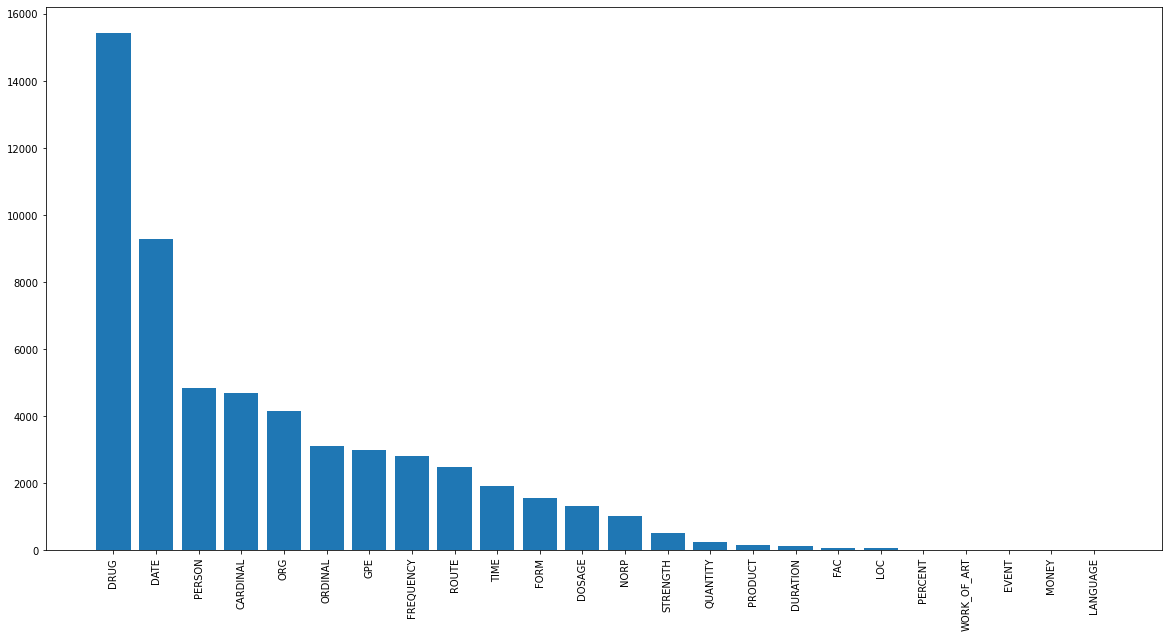

In [13]:
# Count the entities
entities_count = {}
entities_dic = {}

for i in range(len(dataset_p)):
    # Get the entities from the text
    text = dataset_p.loc[i, 'tokens']
    doc_web_sm = nlp(text)

    doc_med7 = med7(text)
    docs = [doc_web_sm, doc_med7]

    #  Get the entities from the text
    combined_entities = []
    for doc in docs:         
        combined_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

    # Count the entities
    for ent in combined_entities:
        if ent[1] in entities_count:
            entities_count[ent[1]] += 1
            entities_dic[ent[1]].append(ent[0])
        else:
            entities_count[ent[1]] = 1
            entities_dic[ent[1]] = [ent[0]]

# Sort the entities by count
entities_count = dict(sorted(entities_count.items(), key=lambda item: item[1], reverse=True))

# Plot the entities
plt.figure(figsize=(20,10))
plt.bar(entities_count.keys(), entities_count.values())
plt.xticks(rotation=90)
plt.show()


In [14]:
print('med7 entities')
for ent in entities_dic:
    if ent in med7.pipe_labels['ner']:
        print(ent, ': ', entities_dic[ent][:3])

med7 entities
DRUG :  ['lidocaine', 'colace', 'proscar']
ROUTE :  ['intravenous', 'iv', 'intravenous']
FREQUENCY :  ['daily', 'daily', 'daily']
FORM :  ['patch', 'norco', 'tablet']
STRENGTH :  ['pamelor mg', 'g', 'iv mg']
DOSAGE :  ['one', 'cc', 'total cc']
DURATION :  ['six week', 'four hour', 'taken twice day']


In [15]:
print('spacy entities')
for ent in entities_dic:
    if ent in nlp.pipe_labels['ner']:
        print(ent, ': ', entities_dic[ent][:3])

spacy entities
PERSON :  ['mynx', 'xyz abc', 'tobrex']
GPE :  ['anesthesia', 'anesthesia', 'scan']
FAC :  ['mynx closure', 'macrodantin hydralazine physical', 'hour ampicillin']
NORP :  ['scan', 'allis', 'meatus']
ORG :  ['anesthesia department digital rectal', 'abc abc', 'abc']
TIME :  ['daytime', 'three hour', 'morning']
DATE :  ['five year', 'today', 'reported week']
ORDINAL :  ['first', 'second', 'third']
CARDINAL :  ['two', 'transcription', 'one']
PRODUCT :  ['tympanic', 'tympanic', 'tympanic']
QUANTITY :  ['foot inch', 'approximately ml nonionic', 'two x mm']
LOC :  ['zuba', 'hagl lesion', 'po digoxin']
PERCENT :  ['ejection fraction percent', 'minus ten percent percent', 'ii percent']
WORK_OF_ART :  ['gram fluid surface', 'gram fluid surface', 'anesthesia tympanic membrane']
MONEY :  ['e penny', 'e penny', 'several bolus fluid tachycardia']
LANGUAGE :  ['english', 'spanish', 'spanish']
EVENT :  ['vietnam', 'vietnam', 'provera advair']


After the midterm presentation, we received feedback regarding ambiguities in our Named Entity Recognition (NER) entities and suggestions on how to enhance the model by avoiding lemmatization for NER recognition. Firstly, our ambiguities arose from the model sometimes assigning 'CARDINAL' and other times 'DOSAGE'. We couldn't merge them or eliminate one, as 'DOSAGE' also includes terms that may not be captured by 'CARDINAL', such as single. Furthermore, not every instance of a cardinal number implies a dosage of a medication.

Secondly, as demonstrated at the end of our notebook, not normalizing the data does not yield better results.

Additionally, in text 4671, our model successfully recognizes some routes of medication administration (such as endotracheal or ear) but fails to identify others that we have found (such as oral or nasal). It's important to note that the model is not failing; rather, the texts are challenging, containing numerous medical terms that, as non-experts, we may not have considered. Upon visually inspecting various texts, we can conclude that we have developed a robust model for recognizing drugs in medical texts.

As seen in the printed examples from the med8 and english models, the recognized entities make sense and are correct.

##### Describe how NER type information could help in other NLP use cases.

NER can improve the understanding of texts and enable more advanced processing of text. The following are some examples where NER type information can benefit NLP applications:

1. **Information Extraction**: NER can identify and classify entities, such as people, organizations, locations, dates, and more. This information is crucial for extracting structured data from unstructured text (legal documents, forms, news).

2. **Sentiment Analysis**: identifying that a positive sentiment is expressed towards a particular brand or product in customer reviews can be valuable for businesses.

3. **Question Answering**: NER can assist in locating entities within a text that are relevant to user queries.

4. **Machine Translation**: NER can help identify and preserve the entities during the translation process, ensuring that names, places, and other important entities remain consistent across languages.
 NER can help identify sensitive information, such as personal names, addresses, or credit card numbers, and facilitate data protection measures.

In summary, NER type information serves as a foundational element in many NLP applications, enhancing their ability to understand, extract, and act on information in text, making them more powerful and context-aware.

#### NER without text processing

We also applied the standard NER classifier from spaCy without text preprocessing. Because we can't use the same annotations from preprocessed data, we need to annotate it again. It seems that the scores are worse.

In [16]:
#Retrieve NE 
def retrieve_NE(text):
    doc = nlp(text) 
    ents = dict((e.text, e.label_) for e in doc.ents)
    for key, value in ents.items():
        print(f"\"{key}\"->{value}, ", end="")
    print("")
    return doc, ents

print("Found NE for Doc 1:")
doc1, ents_1 = retrieve_NE(dataset["train"][951]["text"])
print("Found NE for Doc 2:")
doc2, ents_2 = retrieve_NE(dataset["train"][4794]["text"])

Found NE for Doc 1:
"58-year-old"->DATE, "African-American"->NORP, "16 years"->DATE, "X."->PERSON, "second"->ORDINAL, "Hospital Center"->FAC, "four years"->DATE, "September 2009"->DATE, "three"->CARDINAL, "90 days"->DATE, "State Services"->ORG, "these 90 days"->DATE, "one"->CARDINAL, "September 2008"->DATE, "two sick days"->DATE, ",In July of this year"->DATE, "Ph.D."->WORK_OF_ART, "Comprehensive Independent Medical Evaluation"->ORG, "08/14/2009"->DATE, "08/27/2009"->DATE, "Henry Fein"->PERSON, "M.D."->GPE, "09/23/2009"->DATE, "20/30"->CARDINAL, "daily"->DATE, "1991"->DATE, "approximately five"->CARDINAL, "the past year"->DATE, ",OTHER MEDICAL"->PERSON, "hemangioma"->ORG, "C7"->CARDINAL, "C6-C7"->PRODUCT, "GERD"->ORG, "1976"->DATE, "1974"->DATE, "2007"->DATE, "approximately seven to eight hours"->DATE, "NovoLog"->DATE, "Topamax"->PERSON, "Naprosyn"->PERSON, "two"->CARDINAL, "four"->CARDINAL, "North Carolina"->GPE, "sixth"->ORDINAL, "nine"->CARDINAL, "third"->ORDINAL, "60"->CARDINAL, "9

In [17]:
# Get ground truth from annotations which were manually labelled with https://tecoholic.github.io/ner-annotator/
def get_ground_truth(file_name):
    file = open(file_name, "r")
    annotations = json.load(file)
    return annotations['annotations'][0][1]  

ground_truth_1 = get_ground_truth("annotations_1.json")
ground_truth_2 = get_ground_truth("annotations_2.json")

In [18]:
#Calculcate scores
from spacy.training import Example
def print_scores(docs_with_ground_truth):
    scorer = Scorer()
    scores = scorer.score(docs_with_ground_truth) 
    entities_precision=scores["ents_p"]
    entities_recall=scores["ents_r"]
    entities_f1=scores["ents_f"]
    entities_per_type=scores["ents_per_type"]
    
    #print scores
    print(f"Precision: {entities_precision}")
    print(f"Recall: {entities_recall}")
    print(f"F1-Score: {entities_f1}")


docs_with_ground_truth = [Example.from_dict(doc1, ground_truth_1), Example.from_dict(doc2, ground_truth_2)]
print("Scores:")
print_scores(docs_with_ground_truth) 

Scores:
Precision: 0.25396825396825395
Recall: 0.2882882882882883
F1-Score: 0.270042194092827
